<a href="https://colab.research.google.com/github/ArielFix/DLINtroProject/blob/main/NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import HTML
import subprocess

branch = subprocess.check_output(["git", "rev-parse", "--abbrev-ref", "HEAD"]).decode()[:-1]
HTML('<a href="https://colab.research.google.com/github/ArielFix/DLINtroProject/blob/{branch}/NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>'.format(branch=branch))

CalledProcessError: ignored

#**RoBERTa Model** 

## Setup Commands

In [ ]:
!git init .
!git remote add origin https://github.com/ArielFix/DLINtroProject.git
!git fetch
!git checkout main

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import model_selection
from sklearn.metrics import f1_score
import numpy as np
import torch
from torch.utils.data import dataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [12]:
from google.colab import drive
import os
import sys

drive.mount('/content/gdrive')
train_path = '/content/gdrive/MyDrive/NLP_Project/data/augmented_train.csv'
augumented_data_train_path = '/content/gdrive/MyDrive/NLP_Project/data/augmented_train.csv'
augumented_data_train_path_v2 = '/content/gdrive/MyDrive/NLP_Project/data/augmented_train_v2.csv'
test_path = '/content/gdrive/My Drive/NLP_Project/data/test.csv'
sample_submission_path = '/content/gdrive/MyDrive/NLP_Project/data/sample_submission.csv'

GOOGLE_DRIVE_PATH = '/content/gdrive/MyDrive/NLP_Project'
sys.path.append(GOOGLE_DRIVE_PATH)
print(os.listdir(GOOGLE_DRIVE_PATH))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['README.md', 'test_augs.py', 'requirements.txt', 'get_roberta_model.py', 'NLP_Project.ipynb', '.gitignore', 'utilities', '.idea', 'data', 'roberta', 'model_overfitdata.pk', 'model_b750_lr003_val_acc_0.749083638787071_augumented_data.pk', 'model_b500_lr003_val_acc_0.7525318099195015_original_data.pk', 'augmentations', 'model_b700_lr003_val_acc_0.7811116576487949_augumented_data_v2.pk', 'model_extra_classifier_b750_lr4e-4_val_acc_0.837245696400626_clean_augumented_data_v2.pk', 'model_extra_classifier_b800_lr1e-3_val_acc_0.7843236409608092_clean_augumented_data_v2.pk', 'model_extra_classifier_b800_lr1e-3_val_acc_0.7830233667143537_clean_augumented_data_v2.pk', 'pretrained', 'NLP_Project Roberta.ipynb']


In [13]:
!echo "This may take a while:"
%pip install -q -r /content/gdrive/MyDrive/NLP_Project/requirements.txt # fill here the path to the requirement file

This may take a while:


##Data

Now qe will load the data and observe a sample of it


In [ ]:
augumented_train_df = pd.read_csv(augumented_data_train_path)
augumented_train_df_v2 = pd.read_csv(augumented_data_train_path_v2)
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,1,NaN,NaN,Our human_activity are the understanding of th...,1
2,1,NaN,NaN,Our Deeds are the Reason of this # May ALLAH F...,1
3,1,NaN,NaN,Our Deeds are forgive deed the Allah Reason of...,1
4,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1


**A quick look at our data**
Let's look at our data... first, some examples of what is NOT a disaster tweet.

In [ ]:
print('\n' .join(map(str, train_df[train_df["target"] == 0]["text"].values[0:5])))


What's up man?
What's upwards human_being?
's  man?
What's up serviceman man?
What's up man?


And some examples of what is a disaster tweet.

In [ ]:
print('\n' .join(map(str, train_df[train_df["target"] == 1]["text"].values[0:5])))

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Our human_activity are the understanding of this #earthquake May Allah forgive us all
Our Deeds are the Reason of this # May ALLAH Forgive us all
Our Deeds are forgive deed the Allah Reason of this America #earthquake May ALLAH Forgive us all
Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all


The words contained in each tweet are a good indicator of whether they're about a real disaster or not. This is not entirely correct, but it's a great place to start.

We'll use scikit-learn's 'train_test_split' for splitting the train data to train and validation sets for monitoring the model training.

In [ ]:
train_df, val_df = model_selection.train_test_split(train_df, test_size=0.1, train_size=0.9, stratify=train_df['target'])

**Our model**

As we mentioned above, we think the words contained in each tweet are a good indicator of whether they're about a real disaster or not. The presence of particular word (or set of words) in a tweet might link directly to whether or not that tweet is real.

We want to modify [twitter-roberta-sentiment](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment) for the classification task of disaster tweets.
First let's load the pretrained model.  
We will use helper functions we implemented on .py files.  
'GetPretrainedRoberta' class is a constructor for the pretrained RoBERTa model and a tokenizer.  

We will print the 'classifier' module of the model in ordet to observe the architecture.

In [ ]:
from pretrained.get_pretrained_roberta import GetPretrainedRoberta 

roberta = GetPretrainedRoberta() #init pretrained roberta model and tokenizer
print("Classifier module")
roberta.model.classifier.modules # Shows model's modules

Classifier module


<bound method Module.modules of RobertaClassificationHead(
  (dense): Linear(in_features=768, out_features=768, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (out_proj): Linear(in_features=768, out_features=3, bias=True)
)>

As we can see, the 'classifier' module contains three layers.  
dense: a linear layer with input and output of 768 and bias.  
dropout: dropout layer - a regularizer with probability of 10% to drop (zero out) neurunes.  
out_proj: Linear layer with 768 inputs and 3 outputs.  

This model were used for sentiment analysis with classes for bad, neutral, good.  
The disaster clssification model should have only two outputs:  
1. Disaster.  
2. Not disaster.

We will change the linear layer 'out'proj' with 3 outputs into a linear layer with 2 outputs.
Additioanly, we want to fine tune the pretained roberta model with the new output layer so we will freeze the entire model except the 'Classifier' module which includes the last layer.  
The function 'modify_binary_output' changes the last layer of the classifier into 768 inputs and 2 outputs layer and adds a softmax to the end of the process.  
The function 'modify_only_train_calssifier' freezes the parameters of the model except for the 'Classifier' module for training only the classifier.

In [ ]:
from pretrained.modify_roberta import ModifyRoberta

ModifyRoberta.modify_binary_output(roberta.model) #change output layer to linear -> sigmoid
ModifyRoberta.modify_only_train_calssifier(roberta.model) #freeze the parameters except the 'Classifier' module
print("New classifier module")
roberta.model.classifier.modules


New classifier module


<bound method Module.modules of RobertaClassificationHead(
  (dense): Linear(in_features=768, out_features=768, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (out_proj): Sequential(
    (0): Linear(in_features=768, out_features=2, bias=True)
    (1): LogSoftmax(dim=1)
  )
)>

We can see above that the last layer ('out_proj') changed as described above

In [ ]:
roberta.model.classifier.out_proj[0].reset_parameters

<bound method Linear.reset_parameters of Linear(in_features=768, out_features=2, bias=True)>

Now we should preprocess and prepare the data for the model training.  
'Utilities' class holds functions for preprocessing the data.
As a perliminary preprocessing we will remove all the rows that holds null data.  
The function 'preprocess_text_list' takes a list of strings as input and preprocess the straings by turning all '@...' into '@user' and turning all urls into 'http' which can be tokenized at the trainig phase by the tokenizer.


In [ ]:
from utilities.preprocess import Utilities

val_df.dropna(axis=0, inplace=True)
val_df.reset_index(drop=True, inplace=True)
train_df.dropna(axis=0, inplace=True)
train_df.reset_index(drop=True, inplace=True)

train_text, train_target = train_df['text'].to_list(), train_df['target']
Utilities().preprocess_text_list(train_text)
train_data = pd.DataFrame()
train_data['text'], train_data['target'] = train_text, train_df['target']
val_text = val_df['text'].to_list()
Utilities().preprocess_text_list(val_text)
val_data = pd.DataFrame()
val_data['text'], val_data['target'] = val_text, val_df['target']



And let's see how a sample data tokenized by the tokenizer

In [ ]:
roberta.tokenizer(train_data['text'][train_data.index[0:3]].to_list(), return_tensors='pt', padding=True)

{'input_ids': tensor([[    0,   620,  9707,  3521,  2451,    30, 18621,  4742,  2054,     2,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1],
        [    0,  1558,   151,  9593,    25,   886,   668,  8344,   687,  1829,
           268, 34505,  8493,     7,  1871,  1611,     4,   849, 10448,   219,
         17260, 44454,   640,    90,     4,   876,    73,    90,   387,  4429,
           139, 27457, 43820, 44454,   640,    90,     4,   876,    73,  1872,
           428, 42631,   534,  5433, 23858,     2],
        [    0,  1039, 12105,   787, 12105,   787, 12105, 15983, 15983,    99,
           114,    38,   146,     5,   593,  5666,    41,  6978, 11657,    11,
             5,  1437,  2808,    83,  8640,  4154, 28073,  4014,  3411,   448,
             

We can notice that the tokenizer creates two tensors:  
1. 'input_ids' - includes the word indexes from the dictioanry, we can also see that padding uses '1' to equalize the tensor's second dimension length.
2. 'attention_mask' - includes the mask for the 'input_ids' tensor, which includes '1' for actual word in 'input_ids' and '0' for padded values in it.

Now we will verify that our modified model enable to overfit a sample of the training data.
The 'RobertaHandler' class holds the methods for training and calculate the f1 score of the model (train and validation data) on each epoch.  
Additionally its holds the plotting function for the losses and f1 scores o=of the model for the training data and the validation data.

In [ ]:
from roberta.roberta_handle import RobertaHandler as RH

handler = RH()
try_train = handler.train_roberta_model(val_data=train_data[0:15] ,batch_size=15, check_point_path=None, learning_rate=1e-2, num_epoches=30, train_data=train_data[0:15], model=roberta)

====> Epoch: 1 Average train loss: 0.0165, train acc: 0.7143, Average val loss: 0.0315, val acc: 0.7143
====> Epoch: 2 Average train loss: 0.0470, train acc: 1.0000, Average val loss: 0.0116, val acc: 1.0000
====> Epoch: 3 Average train loss: 0.0252, train acc: 0.8182, Average val loss: 0.0213, val acc: 0.8182
====> Epoch: 4 Average train loss: 0.0333, train acc: 0.8182, Average val loss: 0.0248, val acc: 0.8182
====> Epoch: 5 Average train loss: 0.0424, train acc: 0.8182, Average val loss: 0.0180, val acc: 0.8182
====> Epoch: 6 Average train loss: 0.0192, train acc: 1.0000, Average val loss: 0.0108, val acc: 1.0000
====> Epoch: 7 Average train loss: 0.0204, train acc: 1.0000, Average val loss: 0.0085, val acc: 1.0000
====> Epoch: 8 Average train loss: 0.0098, train acc: 0.9412, Average val loss: 0.0121, val acc: 0.9412
====> Epoch: 9 Average train loss: 0.0183, train acc: 0.9412, Average val loss: 0.0143, val acc: 0.9412
====> Epoch: 10 Average train loss: 0.0242, train acc: 0.9412, A

Let's plot the training and validation acuracies and losses

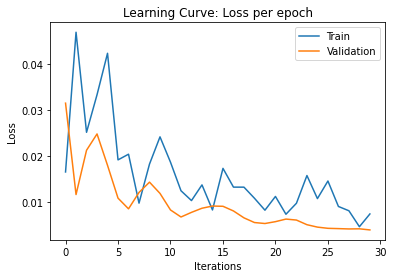

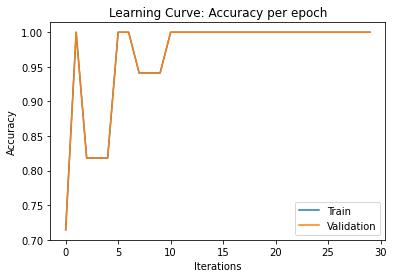

In [ ]:
RH.plot_learning_curve(*try_train)

according to the plots above, it seem that the model overfitted the data well (f1 score of 1) and we are ready for training over all of the data.

In [ ]:
roberta.model.save_pretrained('/content/gdrive/My Drive/NLP_Project/model_overfitdata.pk')

In [ ]:
from pretrained.get_pretrained_roberta import GetPretrainedRoberta 
from pretrained.modify_roberta import ModifyRoberta

roberta_model = GetPretrainedRoberta()
ModifyRoberta.modify_binary_output(roberta_model.model) 
ModifyRoberta.modify_only_train_calssifier(roberta_model.model)

In [ ]:
from roberta.roberta_handle import RobertaHandler as RH

handler = RH()

trained_softmax = handler.train_roberta_model(weight_decay=1e-3 ,val_data=val_data ,batch_size=500, check_point_path=None, learning_rate=1e-3, num_epoches=30, train_data=train_data, model=roberta_model)


====> Epoch: 1 Average train loss: 0.0012, train acc: 0.7034, Average val loss: 0.0011, val acc: 0.7003
====> Epoch: 2 Average train loss: 0.0011, train acc: 0.7165, Average val loss: 0.0010, val acc: 0.7113
====> Epoch: 3 Average train loss: 0.0010, train acc: 0.7282, Average val loss: 0.0010, val acc: 0.7255
====> Epoch: 4 Average train loss: 0.0010, train acc: 0.7352, Average val loss: 0.0010, val acc: 0.7347
====> Epoch: 5 Average train loss: 0.0010, train acc: 0.7369, Average val loss: 0.0010, val acc: 0.7357
====> Epoch: 6 Average train loss: 0.0010, train acc: 0.7389, Average val loss: 0.0009, val acc: 0.7409
====> Epoch: 7 Average train loss: 0.0010, train acc: 0.7474, Average val loss: 0.0009, val acc: 0.7451
====> Epoch: 8 Average train loss: 0.0010, train acc: 0.7405, Average val loss: 0.0009, val acc: 0.7381
====> Epoch: 9 Average train loss: 0.0010, train acc: 0.7520, Average val loss: 0.0009, val acc: 0.7487
====> Epoch: 10 Average train loss: 0.0010, train acc: 0.7531, A

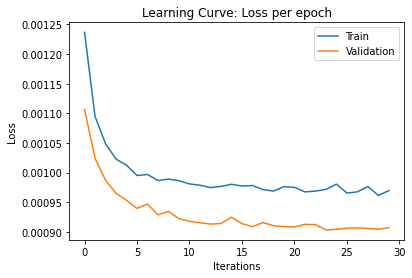

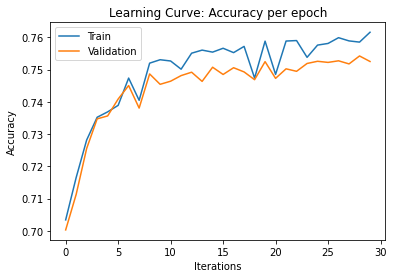

In [ ]:
RH.plot_learning_curve(*trained_softmax)

The plots above and f1 score of the model shows that we trained the model well with no overfir/ underfit, but still, we want to get a better results.

In [ ]:
roberta_model.model.save_pretrained(f'/content/gdrive/My Drive/NLP_Project/model_b500_lr003_val_acc_{trained_softmax[4][-1]}_original_data.pk')

In order to get better f1 score we will try to use agumented data:

In [ ]:
aug_train_df, aug_val_df = model_selection.train_test_split(augumented_train_df, test_size=0.15, train_size=0.85, stratify=augumented_train_df['target'])

aug_val_df.dropna(axis=0, inplace=True)
aug_val_df.reset_index(drop=True, inplace=True)
aug_train_df.dropna(axis=0, inplace=True)
aug_train_df.reset_index(drop=True, inplace=True)

aug_train_text, aug_train_target = aug_train_df['text'].to_list(), aug_train_df['target']
Utilities().preprocess_text_list(aug_train_text)
aug_train_data = pd.DataFrame()
aug_train_data['text'], aug_train_data['target'] = aug_train_text, aug_train_df['target']
aug_val_text = aug_val_df['text'].to_list()
Utilities().preprocess_text_list(aug_val_text)
aug_val_data = pd.DataFrame()
aug_val_data['text'], aug_val_data['target'] = aug_val_text, aug_val_df['target']

In [ ]:
from pretrained.get_pretrained_roberta import GetPretrainedRoberta 
from pretrained.modify_roberta import ModifyRoberta

roberta_model_aug_data = GetPretrainedRoberta()
ModifyRoberta.modify_binary_output(roberta_model_aug_data.model) 
ModifyRoberta.modify_only_train_calssifier(roberta_model_aug_data.model)

In [ ]:
from roberta.roberta_handle import RobertaHandler as RH

handler = RH()

trained_aug_data = handler.train_roberta_model(val_data=aug_val_data ,batch_size=1500, check_point_path=None, learning_rate=4e-2, num_epoches=20, train_data=aug_train_data, model=roberta_model_aug_data)


====> Epoch: 1 Average train loss: 0.0011, train acc: 0.6729, Average val loss: 0.0007, val acc: 0.6755
====> Epoch: 2 Average train loss: 0.0005, train acc: 0.6320, Average val loss: 0.0004, val acc: 0.6317
====> Epoch: 3 Average train loss: 0.0004, train acc: 0.7486, Average val loss: 0.0003, val acc: 0.7442
====> Epoch: 4 Average train loss: 0.0003, train acc: 0.7554, Average val loss: 0.0003, val acc: 0.7468
====> Epoch: 5 Average train loss: 0.0003, train acc: 0.7557, Average val loss: 0.0003, val acc: 0.7458
====> Epoch: 6 Average train loss: 0.0003, train acc: 0.7589, Average val loss: 0.0003, val acc: 0.7534
====> Epoch: 7 Average train loss: 0.0003, train acc: 0.7613, Average val loss: 0.0003, val acc: 0.7554
====> Epoch: 8 Average train loss: 0.0003, train acc: 0.7537, Average val loss: 0.0003, val acc: 0.7460
====> Epoch: 9 Average train loss: 0.0003, train acc: 0.7412, Average val loss: 0.0003, val acc: 0.7324
====> Epoch: 10 Average train loss: 0.0003, train acc: 0.7551, A

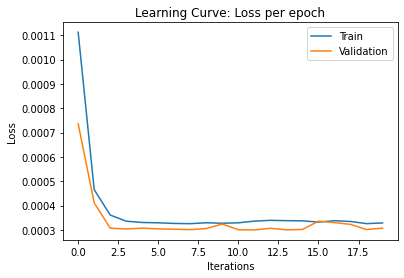

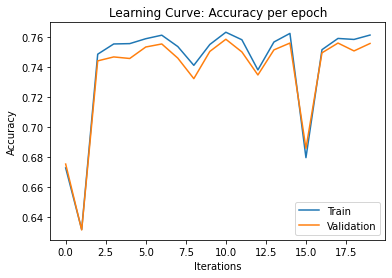

In [ ]:
RH.plot_learning_curve(*trained_aug_data)

In [ ]:
roberta_model_aug_data.model.save_pretrained(f'/content/gdrive/My Drive/NLP_Project/model_b750_lr003_val_acc_{trained_aug_data[4][-1]}_augumented_data.pk')

As we can see, the augumented data improved the model a little but it still seems like we can improve our predictions.
Let's see what will be our f1 score for the test.

In [ ]:
roberta_model_aug_data.model.eval()
results = pd.read_csv(sample_submission_path)
test_data = test_df["text"].to_list()
test_results = []
for i in range(len(test_df["text"])):
  result = torch.argmax(roberta_model_aug_data.model.forward(**roberta_model_aug_data.tokenizer(test_data[i], return_tensors='pt', padding=True).to(device)).logits).to('cpu').item()
  test_results.append(result)

results['target'] = test_results
results.to_csv("submission.csv", index=False)

For submitting the results we will run the next 3 cells (kaggle json should be uploaded on th 'choose file' button in the cell below.

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"arielfixler","key":"d1f8d7cc349ae4484d6617532b9e8a93"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
# submit the file to kaggle
!kaggle competitions submit -c nlp-getting-started -f submission.csv -m "Message"

100% 22.2k/22.2k [00:00<00:00, 107kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets

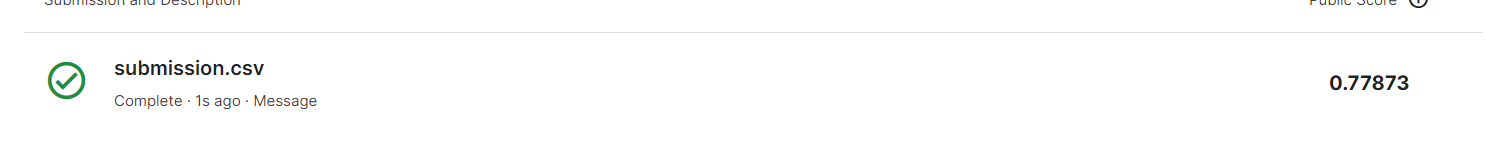

We got f1 score of 0.77873, it's a good score but let's see if we can get even better.

Let's try to use more augmentations, for that we have a second version of augumented data with additional augmentations.

In [ ]:
aug_train_df_v2, aug_val_df_v2 = model_selection.train_test_split(augumented_train_df_v2, test_size=0.15, train_size=0.85, stratify=augumented_train_df_v2['target'])

aug_val_df_v2.dropna(axis=0, inplace=True)
aug_val_df_v2.reset_index(drop=True, inplace=True)
aug_train_df_v2.dropna(axis=0, inplace=True)
aug_train_df_v2.reset_index(drop=True, inplace=True)

aug_train_text_v2, aug_train_target_v2 = aug_train_df_v2['text'].to_list(), aug_train_df_v2['target']
Utilities().preprocess_text_list(aug_train_text_v2)
aug_train_data_v2 = pd.DataFrame()
aug_train_data_v2['text'], aug_train_data_v2['target'] = aug_train_text_v2, aug_train_df_v2['target']
aug_val_text_v2 = aug_val_df_v2['text'].to_list()
Utilities().preprocess_text_list(aug_val_text_v2)
aug_val_data_v2 = pd.DataFrame()
aug_val_data_v2['text'], aug_val_data_v2['target'] = aug_val_text_v2, aug_val_df_v2['target']


In [ ]:
from pretrained.get_pretrained_roberta import GetPretrainedRoberta 
from pretrained.modify_roberta import ModifyRoberta

roberta_model_aug_data_v2 = GetPretrainedRoberta()
ModifyRoberta.modify_binary_output(roberta_model_aug_data_v2.model) 
ModifyRoberta.modify_only_train_calssifier(roberta_model_aug_data_v2.model)

In [ ]:
from roberta.roberta_handle import RobertaHandler as RH

handler = RH()

trained_aug_data_v2 = handler.train_roberta_model(weight_decay=1e-3 ,val_data=aug_val_data_v2 ,batch_size=700, check_point_path=None, learning_rate=4e-4, num_epoches=30, train_data=aug_train_data_v2, model=roberta_model_aug_data_v2)


====> Epoch: 1 Average train loss: 0.0008, train acc: 0.7480, Average val loss: 0.0006, val acc: 0.7603
====> Epoch: 2 Average train loss: 0.0007, train acc: 0.7673, Average val loss: 0.0006, val acc: 0.7721
====> Epoch: 3 Average train loss: 0.0007, train acc: 0.7673, Average val loss: 0.0006, val acc: 0.7689
====> Epoch: 4 Average train loss: 0.0007, train acc: 0.7640, Average val loss: 0.0006, val acc: 0.7719
====> Epoch: 5 Average train loss: 0.0007, train acc: 0.7697, Average val loss: 0.0006, val acc: 0.7733
====> Epoch: 6 Average train loss: 0.0007, train acc: 0.7713, Average val loss: 0.0006, val acc: 0.7780
====> Epoch: 7 Average train loss: 0.0007, train acc: 0.7735, Average val loss: 0.0006, val acc: 0.7757
====> Epoch: 8 Average train loss: 0.0007, train acc: 0.7653, Average val loss: 0.0006, val acc: 0.7726
====> Epoch: 9 Average train loss: 0.0007, train acc: 0.7721, Average val loss: 0.0006, val acc: 0.7744
====> Epoch: 10 Average train loss: 0.0007, train acc: 0.7714, A

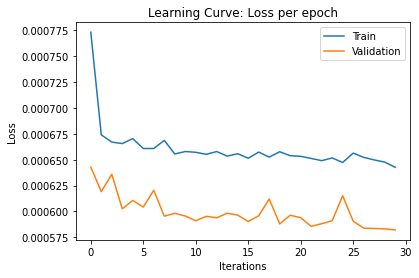

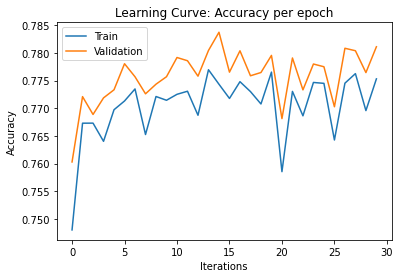

In [ ]:
RH.plot_learning_curve(*trained_aug_data_v2)

According to the plots above we can see that tere wasn't any overfit/ underfit and the model training process seems well with final f1 score over the validation data of 0.7811.

In [ ]:
roberta_model_aug_data_v2.model.save_pretrained(f'/content/gdrive/My Drive/NLP_Project/model_b700_lr003_val_acc_{trained_aug_data_v2[4][-1]}_augumented_data_v2.pk')

Now we will submit our model preditions

In [ ]:
roberta_model_aug_data_v2.model.eval()
results = pd.read_csv(sample_submission_path)
test_data = test_df["text"].to_list()
Utilities().preprocess_text_list(test_data)
test_results = []
for i in range(len(test_df["text"])):
  result = torch.argmax(roberta_model_aug_data_v2.model.forward(**roberta_model_aug_data_v2.tokenizer(test_data[i], return_tensors='pt', padding=True).to(device)).logits).to('cpu').item()
  test_results.append(result)

results['target'] = test_results
results.to_csv("submission.csv", index=False)

In [ ]:
# submit the file to kaggle
!kaggle competitions submit -c nlp-getting-started -f submission.csv -m "Message"

100% 22.2k/22.2k [00:00<00:00, 23.9kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets

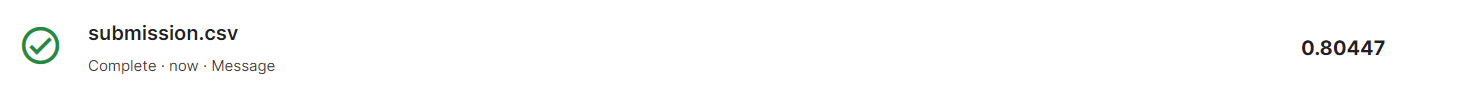

We got f1 score of 0.80447, this is the best score we reached so far.

In order to get better results we will try to change the classifier architecture.  
We will use the function 'modify_binary_output_activation_extended' which changes the classifier, let's look at the changes:

In [17]:
from pretrained.get_pretrained_roberta import GetPretrainedRoberta 
from pretrained.modify_roberta import ModifyRoberta

roberta_model_extra_aug_data_v2 = GetPretrainedRoberta()
ModifyRoberta.modify_binary_output_activation_extended(roberta_model_extra_aug_data_v2.model) 
ModifyRoberta.modify_only_train_calssifier(roberta_model_extra_aug_data_v2.model)
print("New classifier module")
roberta_model_extra_aug_data_v2.model.classifier.modules

New classifier module


<bound method Module.modules of RobertaClassificationHead(
  (dense): Sequential(
    (0): Linear(in_features=768, out_features=768, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=768, out_features=768, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (out_proj): Sequential(
    (0): Linear(in_features=768, out_features=2, bias=True)
    (1): LogSoftmax(dim=1)
  )
)>

As we can see above, the classifier includes additional layers.  
We added LeakyRelu activation layer followed by 10% Dropout layer, the another Linear layer and LeakyRelu activation layer.
The changes of the final layer ('out_proj') remains as before.
Now we will try to train the model with the new classifier and see if we can improve th f1 score.

In [ ]:
from roberta.roberta_handle import RobertaHandler as RH

handler = RH()

trained_extra_aug_data_v2 = handler.train_roberta_model(weight_decay=1e-3 ,val_data=aug_val_data_v2 ,batch_size=800, check_point_path=None, learning_rate=1e-3, num_epoches=15, train_data=aug_train_data_v2, model=roberta_model_extra_aug_data_v2)


====> Epoch: 1 Average train loss: 0.0007, train acc: 0.7556, Average val loss: 0.0006, val acc: 0.7782
====> Epoch: 2 Average train loss: 0.0006, train acc: 0.7624, Average val loss: 0.0006, val acc: 0.7744
====> Epoch: 3 Average train loss: 0.0006, train acc: 0.7652, Average val loss: 0.0006, val acc: 0.7763
====> Epoch: 4 Average train loss: 0.0006, train acc: 0.7778, Average val loss: 0.0006, val acc: 0.7865
====> Epoch: 5 Average train loss: 0.0006, train acc: 0.7647, Average val loss: 0.0005, val acc: 0.7702
====> Epoch: 6 Average train loss: 0.0006, train acc: 0.7791, Average val loss: 0.0006, val acc: 0.7911
====> Epoch: 7 Average train loss: 0.0006, train acc: 0.7808, Average val loss: 0.0005, val acc: 0.7849
====> Epoch: 8 Average train loss: 0.0006, train acc: 0.7839, Average val loss: 0.0005, val acc: 0.7917
====> Epoch: 9 Average train loss: 0.0006, train acc: 0.7763, Average val loss: 0.0005, val acc: 0.7860
====> Epoch: 10 Average train loss: 0.0006, train acc: 0.7887, A

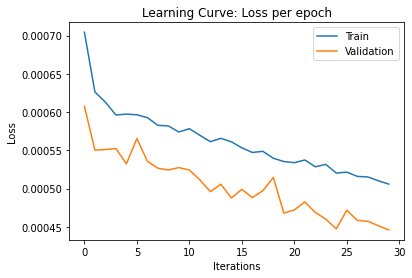

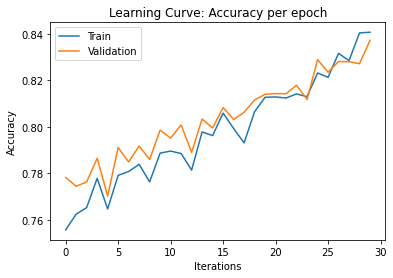

In [ ]:
RH.plot_learning_curve(*trained_extra_aug_data_v2)

The plots above looks like an overfit, let's verify it with a submission

In [ ]:
roberta_model_extra_aug_data_v2.model.save_pretrained(f'/content/gdrive/My Drive/NLP_Project/model_extra_classifier_b750_lr4e-4_val_acc_{trained_extra_aug_data_v2[4][-1]}_clean_augumented_data_v2.pk')

In [ ]:
roberta_model_extra_aug_data_v2.model.eval()
results = pd.read_csv(sample_submission_path)
test_data = test_df["text"].to_list()
Utilities().preprocess_text_list(test_data)
test_results = []
for i in range(len(test_df["text"])):
  result = torch.argmax(roberta_model_extra_aug_data_v2.model.forward(**roberta_model_extra_aug_data_v2.tokenizer(test_data[i], return_tensors='pt', padding=True).to(device)).logits).to('cpu').item()
  test_results.append(result)

results['target'] = test_results
results.to_csv("submission.csv", index=False)

In [ ]:
# submit the file to kaggle
!kaggle competitions submit -c nlp-getting-started -f submission.csv -m "Message"

100% 22.2k/22.2k [00:01<00:00, 13.5kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets

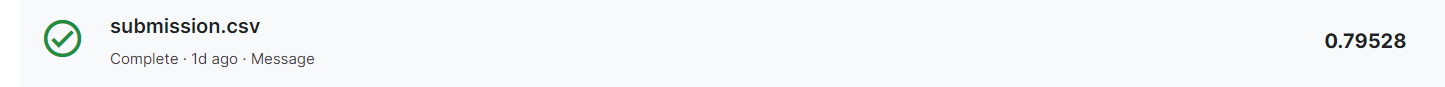

As we can see, the f1 score of the submission (test data) is much lower than the f1 score of the validation data while training.

Let's try with less epochs to avoid overfit

In [16]:
from pretrained.get_pretrained_roberta import GetPretrainedRoberta 
from pretrained.modify_roberta import ModifyRoberta

roberta_model_extra_aug_data_v2 = GetPretrainedRoberta()
ModifyRoberta.modify_binary_output_activation_extended(roberta_model_extra_aug_data_v2.model) 
ModifyRoberta.modify_only_train_calssifier(roberta_model_extra_aug_data_v2.model)

In [ ]:
from roberta.roberta_handle import RobertaHandler as RH

handler = RH()

trained_extra_aug_data_v2 = handler.train_roberta_model(weight_decay=1e-3 ,val_data=aug_val_data_v2 ,batch_size=800, check_point_path=None, learning_rate=1e-3, num_epoches=15, train_data=aug_train_data_v2, model=roberta_model_extra_aug_data_v2)


====> Epoch: 1 Average train loss: 0.0007, train acc: 0.7548, Average val loss: 0.0006, val acc: 0.7397
====> Epoch: 2 Average train loss: 0.0006, train acc: 0.7747, Average val loss: 0.0006, val acc: 0.7677
====> Epoch: 3 Average train loss: 0.0006, train acc: 0.7761, Average val loss: 0.0005, val acc: 0.7645
====> Epoch: 4 Average train loss: 0.0006, train acc: 0.7437, Average val loss: 0.0006, val acc: 0.7281
====> Epoch: 5 Average train loss: 0.0006, train acc: 0.7793, Average val loss: 0.0005, val acc: 0.7625
====> Epoch: 6 Average train loss: 0.0005, train acc: 0.7890, Average val loss: 0.0005, val acc: 0.7736
====> Epoch: 7 Average train loss: 0.0005, train acc: 0.7840, Average val loss: 0.0005, val acc: 0.7718
====> Epoch: 8 Average train loss: 0.0005, train acc: 0.7829, Average val loss: 0.0005, val acc: 0.7691
====> Epoch: 9 Average train loss: 0.0005, train acc: 0.7937, Average val loss: 0.0005, val acc: 0.7812
====> Epoch: 10 Average train loss: 0.0005, train acc: 0.7819, A

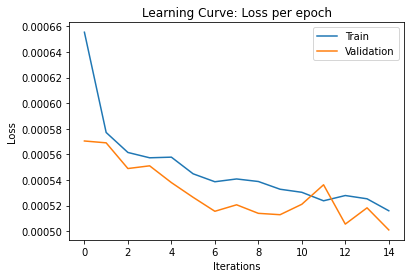

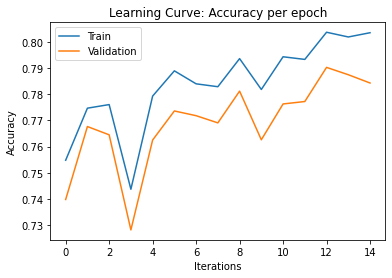

In [ ]:
RH.plot_learning_curve(*trained_extra_aug_data_v2)

According to the plot above we can see that our model trained well with a small risk of overfitting, let's test it with submission.

In [ ]:
roberta_model_extra_aug_data_v2.model.save_pretrained(f'/content/gdrive/My Drive/NLP_Project/model_extra_classifier_b800_lr1e-3_val_acc_{trained_extra_aug_data_v2[4][-1]}_clean_augumented_data_v2.pk')

In [ ]:
roberta_model_extra_aug_data_v2.model.eval()
results = pd.read_csv(sample_submission_path)
test_data = test_df["text"].to_list()
Utilities().preprocess_text_list(test_data)
test_results = []
for i in range(len(test_df["text"])):
  result = torch.argmax(roberta_model_extra_aug_data_v2.model.forward(**roberta_model_extra_aug_data_v2.tokenizer(test_data[i], return_tensors='pt', padding=True).to(device)).logits).to('cpu').item()
  test_results.append(result)

results['target'] = test_results
results.to_csv("submission.csv", index=False)

In [ ]:
# submit the file to kaggle
!kaggle competitions submit -c nlp-getting-started -f submission.csv -m "Message"

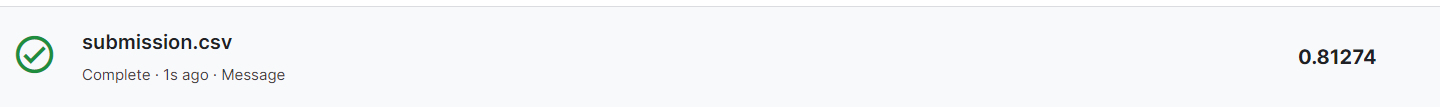

Great! we got a very high f1 score of 0.81274

Maybe the additional layer caused the model to overfit and caused lower score than could be reached with no additional layer.
Now we will try only with activation layer added between both linear layers.

In [ ]:
from pretrained.get_pretrained_roberta import GetPretrainedRoberta 
from pretrained.modify_roberta import ModifyRoberta

roberta_model_activation_aug_data_v2 = GetPretrainedRoberta()
ModifyRoberta.modify_binary_output_activation(roberta_model_activation_aug_data_v2.model) 
ModifyRoberta.modify_only_train_calssifier(roberta_model_activation_aug_data_v2.model)
print("New classifier module")
roberta_model_activation_aug_data_v2.model.classifier.modules


New classifier module


<bound method Module.modules of RobertaClassificationHead(
  (dense): Sequential(
    (0): Linear(in_features=768, out_features=768, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (out_proj): Sequential(
    (0): Linear(in_features=768, out_features=2, bias=True)
    (1): LogSoftmax(dim=1)
  )
)>

In [ ]:
from roberta.roberta_handle import RobertaHandler as RH

handler = RH()

trained_activation_aug_data_v2 = handler.train_roberta_model(weight_decay=1e-3 ,val_data=aug_val_data_v2 ,batch_size=800, check_point_path=None, learning_rate=4e-4, num_epoches=25, train_data=aug_train_data_v2, model=roberta_model_activation_aug_data_v2)


====> Epoch: 1 Average train loss: 0.0007, train acc: 0.7452, Average val loss: 0.0006, val acc: 0.7404
====> Epoch: 2 Average train loss: 0.0006, train acc: 0.7633, Average val loss: 0.0006, val acc: 0.7528
====> Epoch: 3 Average train loss: 0.0006, train acc: 0.7696, Average val loss: 0.0006, val acc: 0.7591
====> Epoch: 4 Average train loss: 0.0006, train acc: 0.7730, Average val loss: 0.0006, val acc: 0.7632
====> Epoch: 5 Average train loss: 0.0006, train acc: 0.7699, Average val loss: 0.0005, val acc: 0.7606
====> Epoch: 6 Average train loss: 0.0006, train acc: 0.7763, Average val loss: 0.0005, val acc: 0.7664
====> Epoch: 7 Average train loss: 0.0006, train acc: 0.7780, Average val loss: 0.0005, val acc: 0.7660
====> Epoch: 8 Average train loss: 0.0006, train acc: 0.7794, Average val loss: 0.0005, val acc: 0.7680
====> Epoch: 9 Average train loss: 0.0006, train acc: 0.7798, Average val loss: 0.0005, val acc: 0.7689
====> Epoch: 10 Average train loss: 0.0005, train acc: 0.7806, A

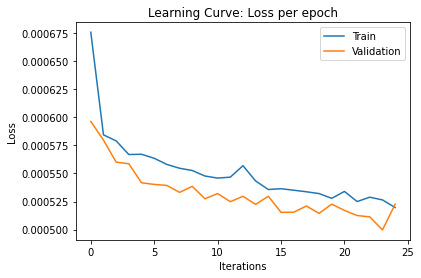

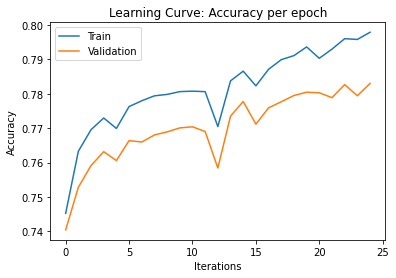

In [ ]:
RH.plot_learning_curve(*trained_activation_aug_data_v2)

According to the plots above we can see that the activation layer is the cause for overfitting, let's check this model score anyway.

In [ ]:
roberta_model_activation_aug_data_v2.model.save_pretrained(f'/content/gdrive/My Drive/NLP_Project/model_extra_classifier_b800_lr1e-3_val_acc_{trained_activation_aug_data_v2[4][-1]}_clean_augumented_data_v2.pk')

In [ ]:
roberta_model_activation_aug_data_v2.model.eval()
results = pd.read_csv(sample_submission_path)
test_data = test_df["text"].to_list()
Utilities().preprocess_text_list(test_data)
test_results = []
for i in range(len(test_df["text"])):
  result = torch.argmax(roberta_model_activation_aug_data_v2.model.forward(**roberta_model_activation_aug_data_v2.tokenizer(test_data[i], return_tensors='pt', padding=True).to(device)).logits).to('cpu').item()
  test_results.append(result)

results['target'] = test_results
results.to_csv("submission.csv", index=False)

In [ ]:
# submit the file to kaggle
!kaggle competitions submit -c nlp-getting-started -f submission.csv -m "Message"

100% 22.2k/22.2k [00:00<00:00, 37.3kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets

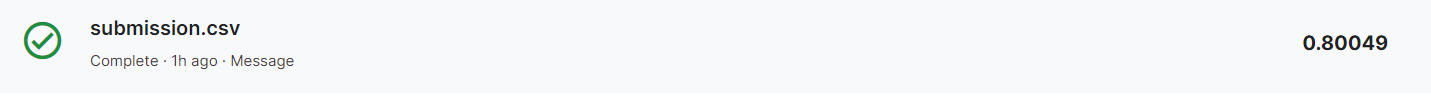

As we can see, the additional LeakyRelu activation layer didn't cause any signicant improvement (regular modified layer with version 2 of augumented got similaer f1 score)

#**Conclusions**  
  
During the research over RoBERTa model for the task we noticed that data is the main key in order to increase the model accuracy.  
We saw that architectural changes as additional linear layer and activation layer caused an overfit which might be overcome by adding more augmentations.  
The overfit shows that maybe manual data cleaning is rewuires which probably will inprove the model accuracy after training on.